In [168]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
import spyx
import spyx.nn as snn

import jax
import jax.numpy as jnp

import haiku as hk

from lif import RecurrentLIF, compute_loss_gradient, eval3
from utils import shift_by_one_time_step


In [170]:
n_in = 3
n_LIF = 2
n_ALIF = 2
n_rec = n_ALIF + n_LIF

dt = 1  # ms
tau_v = 20  # ms
tau_a = 500  # ms
T = 100  # ms
f0 = 100  # Hz

thr = 0.62 
beta = 0.07 * jnp.concatenate([jnp.zeros(n_LIF), jnp.ones(n_ALIF)])
dampening_factor = 0.3
n_ref = 3
decay_out = jnp.exp(-dt / tau_v)

In [171]:
key = jax.random.PRNGKey(2)
inputs = (jax.random.uniform(key, shape=(1, T, n_in)) < f0 * dt / 1000).astype(float)
print(inputs.shape, inputs)

(1, 100, 3) [[[0. 0. 1.]
  [0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 1.]
  [0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 1. 0.]
  [0. 1. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [1. 0. 0.]
  [0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]
  [1. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]
  [0. 1. 1.]
  [0. 0. 1.]
  [0. 0. 1.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [1. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [1. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]


In [172]:
def lsnn2(x, state=None, batch_size=1):
    core = hk.DeepRNN([
        RecurrentLIF(
            n_in,
            n_rec,
            tau=tau_v,
            thr=thr,
            dt=dt,
            dtype=jnp.float32,
            dampening_factor=dampening_factor,
            tau_adaptation=tau_a,
            beta=beta,
            tag='',
            stop_gradients=True,
            w_in_init=None,
            w_rec_init=None,
            n_refractory=n_ref,
            rec=True,
        )
    ])
    if state is None:
        state = core.initial_state(batch_size)
    spikes, hiddens = core(x, state)
    return spikes, hiddens

lsnn2_hk = hk.without_apply_rng(hk.transform(lsnn2))

In [173]:
i0 = jnp.stack([inputs[:,0], inputs[:,0], inputs[:,0],inputs[:,0], inputs[:,0]], axis=0)
print(i0.shape)
params = lsnn2_hk.init(rng=key, x=i0, batch_size=5)
print(params)

(5, 1, 3)
i_in (5, 4)
{'RecurrentLIF': {'w_in': Array([[ 0.7967948 , -0.3821632 , -0.7605332 ,  0.45293623],
       [-0.03456055,  0.65856   ,  0.58331513, -0.10983399],
       [-0.4869853 ,  1.0580422 ,  0.53946483, -0.00187313]],      dtype=float32), 'w_rec': Array([[ 0.2713923 ,  0.86784893,  0.07354291, -0.43423995],
       [ 0.9018898 , -0.1874919 ,  0.18929863,  0.15613334],
       [ 0.2636667 ,  0.32536188,  0.5184128 ,  0.30088994],
       [ 0.22115956, -0.26662493,  0.49525732,  0.11215727]],      dtype=float32)}}


In [174]:
w_in_copy = [[ 0.7967948 , -0.3821632 , -0.7605332 ,  0.45293623],
       [-0.03456055,  0.65856   ,  0.58331513, -0.10983399],
       [-0.4869853 ,  1.0580422 ,  0.53946483, -0.00187313]]
w_in_copy = jnp.array(w_in_copy)

In [175]:
loss, y_out, y_target, w_out, spikes, V, variations = eval3(
    lsnn2, inputs, params, params['RecurrentLIF']['w_rec'], None, None, key,
    n_rec, dt, tau_v, T, 1
)


i_in (1, 4)
i_in (1, 4)
[[0. 0. 1.]] -> [[0. 1. 0. 0.]]
i_in (1, 4)
[[0. 0. 0.]] -> [[0. 0. 1. 0.]]
i_in (1, 4)
[[0. 1. 0.]] -> [[1. 0. 0. 0.]]
i_in (1, 4)
[[0. 0. 0.]] -> [[0. 1. 0. 0.]]
i_in (1, 4)
[[0. 0. 0.]] -> [[0. 0. 1. 0.]]
i_in (1, 4)
[[0. 0. 0.]] -> [[1. 0. 0. 0.]]
i_in (1, 4)
[[0. 0. 0.]] -> [[0. 1. 0. 0.]]
i_in (1, 4)
[[0. 0. 0.]] -> [[0. 0. 0. 0.]]
i_in (1, 4)
[[0. 0. 0.]] -> [[1. 0. 0. 0.]]
i_in (1, 4)
[[0. 0. 0.]] -> [[0. 1. 0. 0.]]
i_in (1, 4)
[[0. 0. 1.]] -> [[0. 0. 1. 0.]]
i_in (1, 4)
[[0. 0. 0.]] -> [[1. 0. 0. 0.]]
i_in (1, 4)
[[0. 1. 0.]] -> [[0. 1. 0. 0.]]
i_in (1, 4)
[[0. 0. 0.]] -> [[0. 0. 1. 0.]]
i_in (1, 4)
[[0. 0. 0.]] -> [[1. 0. 0. 0.]]
i_in (1, 4)
[[0. 0. 0.]] -> [[0. 1. 0. 0.]]
i_in (1, 4)
[[0. 0. 0.]] -> [[0. 0. 0. 0.]]
i_in (1, 4)
[[0. 0. 0.]] -> [[1. 0. 0. 0.]]
i_in (1, 4)
[[0. 1. 0.]] -> [[0. 1. 1. 0.]]
i_in (1, 4)
[[0. 1. 0.]] -> [[0. 0. 0. 0.]]
i_in (1, 4)
[[0. 0. 0.]] -> [[1. 0. 0. 0.]]
i_in (1, 4)
[[0. 0. 0.]] -> [[0. 1. 1. 0.]]
i_in (1, 4)
[[0. 0. 

In [176]:
learning_signals = jnp.einsum("btk,jk->tj", y_out - y_target, w_out)
print("ls", learning_signals)

pre_synpatic_spike_one_step_before = shift_by_one_time_step(spikes)

gradients_eprop, eligibility_traces, _, _ = \
    compute_loss_gradient(learning_signals, pre_synpatic_spike_one_step_before, spikes, V,
                               variations, 
                               dt, thr, tau_a, tau_v, beta, dampening_factor,
                               decay_out, True)
gradients_eprop / jnp.max(jnp.abs(gradients_eprop))

ls [[ 4.87396121e-01 -1.01747799e+00  1.85554162e-01 -1.83139467e+00]
 [-3.05768371e-01  6.38315678e-01 -1.16407566e-01  1.14892697e+00]
 [-6.11080468e-01  1.27567887e+00 -2.32641429e-01  2.29613948e+00]
 [ 2.93616384e-01 -6.12947464e-01  1.11781247e-01 -1.10326588e+00]
 [-5.84041357e-01  1.21923268e+00 -2.22347513e-01  2.19454002e+00]
 [-2.34895512e-01  4.90363002e-01 -8.94259140e-02  8.82621765e-01]
 [-1.82137042e-01  3.80225539e-01 -6.93404973e-02  6.84381366e-01]
 [ 3.20320725e-02 -6.68694898e-02  1.21947723e-02 -1.20360762e-01]
 [ 3.31775188e-01 -6.92606986e-01  1.26308501e-01 -1.24664783e+00]
 [-4.45817322e-01  9.30679023e-01 -1.69724911e-01  1.67516208e+00]
 [ 8.04192794e-04 -1.67881628e-03  3.06160277e-04 -3.02176084e-03]
 [-5.81190288e-01  1.21328080e+00 -2.21262082e-01  2.18382692e+00]
 [ 5.47563910e-01 -1.14308310e+00  2.08460361e-01 -2.05747581e+00]
 [ 3.04403812e-01 -6.35467112e-01  1.15888074e-01 -1.14379966e+00]
 [ 2.09924370e-01 -4.38233763e-01  7.99192712e-02 -7.887924

Array([[ 0.        ,  0.        , -0.37429783,  0.85340023],
       [-0.03725346,  0.        , -0.38795733,  1.        ],
       [-0.02078228,  0.        ,  0.        ,  0.64819926],
       [ 0.        ,  0.        ,  0.        ,  0.        ]],      dtype=float32)

In [177]:
ngep = gradients_eprop / jnp.max(jnp.abs(gradients_eprop))

In [178]:
fun = lambda *x: eval3(*x)[0]
def wrapper(w_rec):
    # w_rec = params['RecurrentLIF']['w_rec']
    # w_rec[0, 0] = w0
    return fun(lsnn2, inputs, params, w_rec, None, None, key, n_rec, dt, tau_v, T, 1)
   

In [179]:

surrogate_grad3 = jax.value_and_grad(fun, argnums=3)(lsnn2, inputs, params, params['RecurrentLIF']['w_rec'].copy(), None, None, key,
    n_rec, dt, tau_v, T, 1)

i_in (1, 4)
i_in (1, 4)
[[0. 0. 1.]] -> Traced<ConcreteArray([[0. 1. 0. 0.]], dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array([[0., 1., 0., 0.]], dtype=float32)
  tangent = Traced<ShapedArray(float32[1,4])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[1,4]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x000001E0AF922950>, in_tracers=(Traced<ShapedArray(float32[1,4]):JaxprTrace(level=1/0)>, Traced<ConcreteArray([[False False False False]], dtype=bool):JaxprTrace(level=1/0)>, Traced<ConcreteArray([[0. 0. 0. 0.]], dtype=float32):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x000001E0B0FB2FC0; to 'JaxprTracer' at 0x000001E0B0FB2DA0>], out_avals=[ShapedArray(float32[1,4])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[1,4] b:bool[1,4] c:f32[1,4]. let
    d:f32[1,4] = select_n b a c
  in (d,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'don

In [180]:
ngep

Array([[ 0.        ,  0.        , -0.37429783,  0.85340023],
       [-0.03725346,  0.        , -0.38795733,  1.        ],
       [-0.02078228,  0.        ,  0.        ,  0.64819926],
       [ 0.        ,  0.        ,  0.        ,  0.        ]],      dtype=float32)

In [181]:
surrogate_grad3[1] / jnp.max(jnp.abs(surrogate_grad3[1]))

Array([[ 0.        ,  0.        , -0.3742977 ,  0.8534004 ],
       [-0.03725344,  0.        , -0.38795722,  1.        ],
       [-0.02078228,  0.        ,  0.        ,  0.6481994 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]],      dtype=float32)

In [182]:
nga = surrogate_grad3[1] / jnp.max(jnp.abs(surrogate_grad3[1]))

In [183]:
jnp.allclose(ngep, nga, atol=1e-3)

Array(True, dtype=bool)

In [184]:
print(T)
jnp.linalg.norm(ngep - nga)

100


Array(2.735553e-07, dtype=float32)

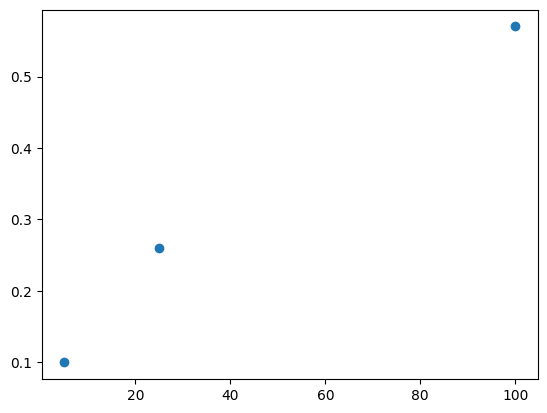

In [185]:
xp = [5,25,100]
yp=[0.1,0.26,0.57]
import matplotlib.pyplot as plt
plt.plot(xp, yp, 'o')